In [11]:
from collections import defaultdict
import itertools as itt
from sys import stdout

import numpy as np
from numpy.polynomial.polynomial import Polynomial, polyfit
from sympy import symbols
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as _A  # imported for "side effects"

import heisenberg

# Relators I've found so far
$$
xy^2x y^{-1}x^{-2}y^{-1} = e  \text{ (}xy\text{ and }yx\text{ commute)} \\
xyx^{-1}y^{-1}xy^{-1}x^{-1}y = e  \text{ (}xy^{-1}x^{-1}y = yxy^{-1}x^{-1}\text{ commute)} \\
$$

[question_about_relators]: https://math.stackexchange.com/q/2272183
[sage_heis_impl]: http://doc.sagemath.org/html/en/reference/groups/sage/groups/matrix_gps/heisenberg.html#sage.groups.matrix_gps.heisenberg.HeisenbergGroup
[sage_heis_pres]: http://doc.sagemath.org/html/en/reference/groups/sage/groups/finitely_presented_named.html#sage.groups.finitely_presented_named.FinitelyGeneratedHeisenbergPresentation

[This question][question_about_relators] claims (implicitly) that these are the only relations you need for the integer Heisenberg group:

$$
  [[x, y], x] = e
  [[x, y], y] = e
$$

Also, Sage Math has a Heisenberg group implementation built in for Heisenberg over the integers. See the docs [here][sage_heis_impl].

It also has a finite presentation of the Heisenberg group over the integers. See the docs [here][sage_heis_pres].

# Experiments
If we try all n-words in $x$ and $y$, which are the identity?

In [25]:
def standardize_product(product):
    """
    Given an n-word made of 3-tuples, put it in a standard form wrt. to the
    Heisenberg operation.
    
    This basically just means moving all the atomically commutative bits to
    the end, then sorting those commutative bits by 
    
    This doesn't do anything fancy. For example, take (-1, 1, 5) * (1, -1, 3).
    This commutes as a pair, because the product of this pair is something
    that only has a z component (z = 5 + 3 + 1 = 9). This function WILL NOT
    move this pair to the end, because it only looks at single items in the
    product, not at products that might commute.
    """
    noncommutative_part = []
    commutative_part = []
    for tup in product:
        if tup[0] == tup[1] and tup[1] == 0:
            commutative_part.append(tup)
        else:
            noncommutative_part.append(tup)
    commutative_part.sort(key=lambda t: t[2])
    return tuple(noncommutative_part + commutative_part)

def get_inverse_combinations_map(S, n):
    """
    Given a generating set S and a positive integer n, return a dict mapping
    each point in P_n(S) to a list of the S-words whose Heisenberg sum is
    that point.

    Note that this is actually S-words modulo a weak kind of Heisenberg
    equivalence -- if there are two S-words that differ by the position of
    some commuting generators, then we don't care about the difference
    between them, so they won't show up as distinct combinations in this map.
    
    For example, if S contains (0, 0, 0), then a point that comes from a
    product that includes zero won't include in its combination list a
    billion variations that are that same product, but with the (0, 0, 0) in
    a slightly different place.
    """
    if n <= 0:
        return {}
    inverted_combinations_map = defaultdict(set)
    for product in itt.product(S, repeat=n):
        # if this errors because product is an iterator and it ran out, then
        # just save tuple(product) and pass it around.
        image = tuple(heisenberg.vectuple_h3_sum(product))
        tuplified_product = standardize_product(tuple(point) for point in product)
        
        items = inverted_combinations_map[image]
        items.add(tuplified_product)
    
    return dict(inverted_combinations_map)

def zero_word_images(S, n):
    """
    Given S and n, generate images showing all combinations of P_n(S) that
    are zero.
    """
    # Compute colors for each point in the generating set S = S_1 \cup S_2
    generators = [
        tuple(point) for point in S
    ]
    
    S_combinations = get_inverse_combinations_map(S, n)

    print(', '.join([str(generator) for generator in generators]))
    plt.figure()
    plt.title("Key")
    plt.xlabel(', '.join([str(generator) for generator in generators]))
    plt.imshow(np.arange(len(generators)).reshape(1, -1))
    
    # Now for each point in the intersection, show the image.
    print("Showing points that give 0!")
    zero_combinations = set()
    
    # Replace each combination with its index into the list of generators.
    # By doing things this way, we can use a colormap to display the image.
    for combination in S_combinations[(0, 0, 0)]:
        replaced = tuple(generators.index(tuple(tup)) for tup in combination)
        zero_combinations.add(replaced)

    # Build the array of all different combinations whose image under the
    # Heisenberg-operator-applying function is this point.
    combinations_matrix = np.stack([
        combination for combination in zero_combinations
    ])
    indices = np.lexsort(combinations_matrix.T)
    nice_combinations_matrix = combinations_matrix[indices, :]
    plt.figure()
    plt.title("Combinations matrix for point t = {}".format(point))
    plt.imshow(nice_combinations_matrix)
        

In [23]:
S = [
    np.array(( 1,  0, 0)),
    np.array(( 0,  1, 0)),
    np.array(( 0, -1, 0)),
    np.array((-1,  0, 0)),
]

In [31]:
n = 4

(1, 0, 0), (0, 1, 0), (0, -1, 0), (-1, 0, 0)
Showing points that give 0!


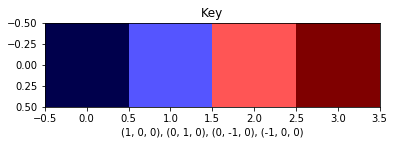

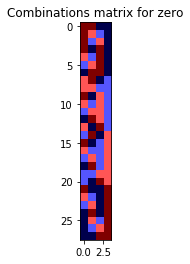

In [32]:
# Compute colors for each point in the generating set S = S_1 \cup S_2
generators = [
    tuple(point) for point in S
]

S_combinations = get_inverse_combinations_map(S, n)

print(', '.join([str(generator) for generator in generators]))
plt.figure()
plt.title("Key")
plt.xlabel(', '.join([str(generator) for generator in generators]))
plt.imshow(np.arange(len(generators)).reshape(1, -1), cmap='seismic')

# Now for each point in the intersection, show the image.
print("Showing points that give 0!")
zero_combinations = set()

# Replace each combination with its index into the list of generators.
# By doing things this way, we can use a colormap to display the image.
for combination in S_combinations[(0, 0, 0)]:
    replaced = tuple(generators.index(tuple(tup)) for tup in combination)
    zero_combinations.add(replaced)

# Build the array of all different combinations whose image under the
# Heisenberg-operator-applying function is this point.
combinations_matrix = np.stack([
    combination for combination in zero_combinations
])
indices = np.lexsort(combinations_matrix.T)
nice_combinations_matrix = combinations_matrix[indices, :]
plt.figure()
plt.title("Combinations matrix for zero")
plt.imshow(nice_combinations_matrix, cmap='seismic')

Well, that was useless.

In [ ]:
def get_inverse_combinations_free(k, n):
    """
    Given a generating set S and a positive integer n, return a dict mapping
    each point in P_n(S) to a list of the S-words whose Heisenberg sum is
    that point.

    Note that this is actually S-words modulo a weak kind of Heisenberg
    equivalence -- if there are two S-words that differ by the position of
    some commuting generators, then we don't care about the difference
    between them, so they won't show up as distinct combinations in this map.
    
    For example, if S contains (0, 0, 0), then a point that comes from a
    product that includes zero won't include in its combination list a
    billion variations that are that same product, but with the (0, 0, 0) in
    a slightly different place.
    """
    if n <= 0:
        return {}
    inverted_combinations_map = defaultdict(set)
    for product in itt.product(S, repeat=n):
        # if this errors because product is an iterator and it ran out, then
        # just save tuple(product) and pass it around.
        image = tuple(np.sum(product))
        tuplified_product = standardize_product(tuple(point) for point in product)
        
        items = inverted_combinations_map[image]
        items.add(tuplified_product)
    
    return dict(inverted_combinations_map)

In [ ]:
heisenberg.